## Vector Error Correction Model ( 벡터오차수정모형)

   - 단위근 검정
   - 차수 설정
   - 공적분 검정 
   - VECM 모형 설정 
   - 인과관계 검정 
   - 충격반응분석
   - 예측

In [1]:
#pip install numpy==1.19.5

In [1]:
import scipy
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [2]:
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
import os

import pandas as pd
import numpy as np
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')


import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools


import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [4]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [5]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR,VECM
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('수출금액.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
#data.dtypes

#data.dtypes --> float type 확인
data['한국수출금액_USD'] = (data['한국수출금액_USD'].str.split()).apply(lambda x: float(x[0].replace(',', '')))

(270, 1)


In [8]:
split = -6
train_data = data['한국수출금액_USD'][0:split] 
test_data = data['한국수출금액_USD'][split:]

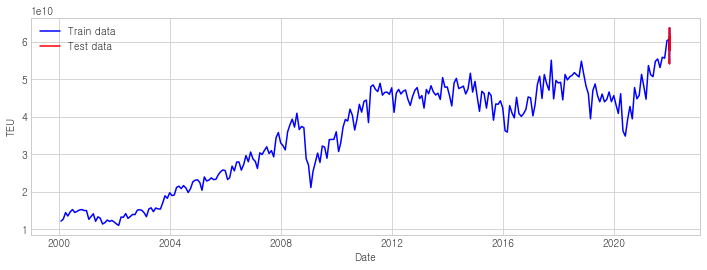

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['한국수출금액_USD'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [7]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('수출금액_최종.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
#data.dtypes

#data.dtypes --> float type 확인
data['한국수출금액_USD'] = (data['한국수출금액_USD'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['화물수송총괄'] = (data['화물수송총괄'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['코스피지수'] = (data['코스피지수'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['코스닥지수'] = (data['코스닥지수'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['환율'] = (data['환율'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['부산항수출금액_1000달러'] = (data['부산항수출금액_1000달러'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
data['부산항수입금액_1000달러'] = (data['부산항수입금액_1000달러'].str.split()).apply(lambda x: float(x[0].replace(',', '')))

(264, 21)


In [8]:
data.describe()

,한국수출금액_USD,한국수입금액_USD,경기종합지수,수출물가지수,수입물가지수,화물수송총괄,코스피지수,코스닥지수,환율,Dubai,다우존스지수,나스닥지수,한국소비자물가지수,미국생산자물가지수,전산업생산지수,실업률,부산항수출금액_1000달러,부산항수입금액_1000달러,반도체수출금액현황,수출단가지수,무역경기확산지수
count,2.640000e+02,2.640000e+02,264.000000,264.000000,264.000000,2.640000e+02,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,2.640000e+02,2.640000e+02,2.640000e+02,264.000000,264.000000
mean,3.523252e+10,3.218020e+10,87.310606,111.821591,104.155303,1.011157e+08,1655.504886,648.243030,1129.493409,61.492083,15544.495000,4282.620076,85.335367,98.961477,88.572727,3.604545,1.053770e+07,7.937359e+06,4.610362e+09,107.604167,53.186364
std,1.337332e+10,1.209851e+10,20.017094,11.318810,22.067721,3.073934e+07,659.229137,255.400619,98.938941,28.592609,6967.068724,3223.902119,12.327556,15.299625,16.987406,0.559857,3.431099e+06,2.535356e+06,2.884922e+09,11.846879,13.234741
min,1.102304e+10,1.047116e+10,56.200000,86.800000,62.800000,1.669310e+05,479.680000,307.480000,915.860000,17.690000,7062.930000,1172.060000,62.393000,70.940000,51.900000,2.600000,4.212740e+06,3.209252e+06,8.673130e+08,77.200000,11.900000
25%,2.325228e+10,2.187783e+10,69.525000,103.675000,91.200000,8.429226e+07,1050.112500,503.587500,1078.927500,37.985000,10467.095000,2119.285000,74.413000,86.380000,73.500000,3.200000,7.254241e+06,5.783653e+06,2.399574e+09,98.375000,44.400000
50%,3.939702e+10,3.534834e+10,85.600000,113.650000,104.000000,1.034534e+08,1881.050000,607.325000,1130.800000,58.790000,12627.300000,2820.590000,87.812500,104.180000,91.400000,3.500000,1.143047e+07,8.881660e+06,4.085099e+09,110.600000,53.000000
75%,4.631255e+10,4.249717e+10,103.300000,120.400000,119.825000,1.229345e+08,2042.212500,707.527500,1182.415000,77.257500,18135.130000,5136.742500,95.632500,109.290000,102.325000,3.900000,1.341750e+07,9.967100e+06,5.771186e+09,117.300000,61.500000
max,6.073412e+10,6.115967e+10,127.700000,139.800000,149.100000,1.497036e+08,3296.680000,2663.700000,1461.980000,131.310000,36338.300000,15644.970000,104.040000,128.740000,129.300000,5.700000,1.650429e+07,1.212610e+07,1.284298e+10,137.100000,86.700000


<AxesSubplot:>

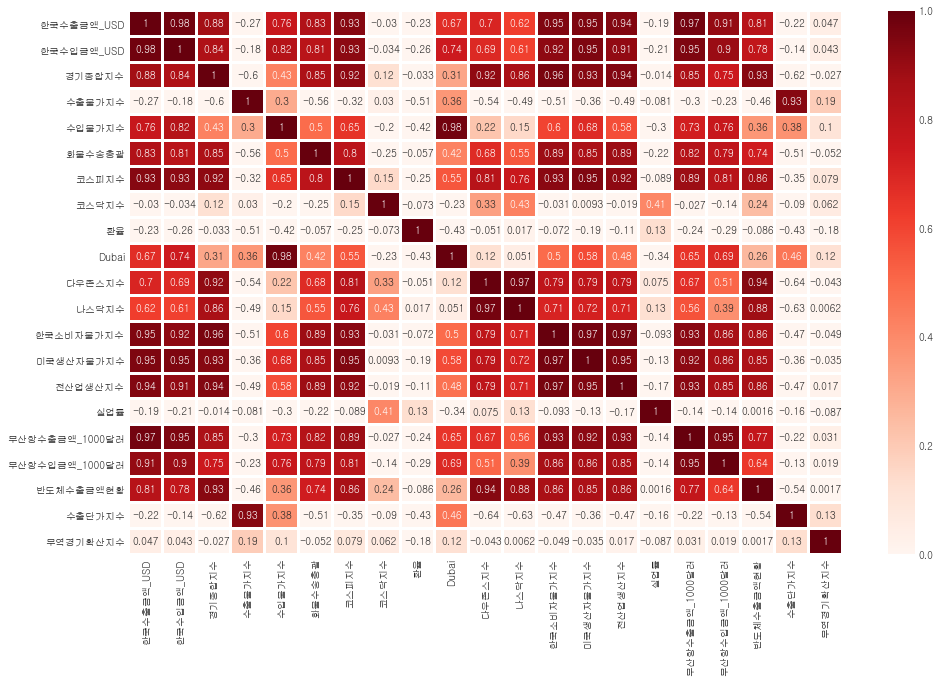

In [9]:
# 상관계수 확인 
plt.rcParams["figure.figsize"] = (16,10)
sns.heatmap(data.corr(), annot=True, cmap='Reds', linewidths=2, vmin=0)

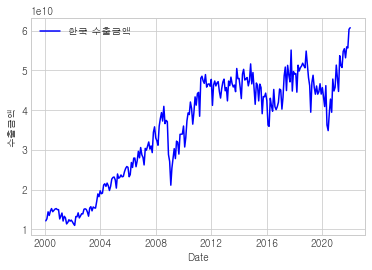

In [10]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('수출금액')
plt.plot(data['한국수출금액_USD'], 'blue', label='한국 수출금액')
plt.legend()

### 단위근 검정
 - H0 : 비정상 시계열 
 - H1 : 정상 시계열

In [11]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'   ADF 검정 : "{name}"', "\n   ", '-'*47)
    print(f' H0 : 단위근 존재 --> 비정상 시계열.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. H0 기각")
        print(f" => 정상 시계열 .")
    else:
        print(f" => P-Value = {p_value}. H0 채택")
        print(f" => 비정상 시계열")
        
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print()

   ADF 검정 : "한국수출금액_USD" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -0.9662
 => P-Value = 0.7654. H0 채택
 => 비정상 시계열

   ADF 검정 : "한국수입금액_USD" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -0.7802
 => P-Value = 0.8249. H0 채택
 => 비정상 시계열

   ADF 검정 : "경기종합지수" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = 2.7759
 => P-Value = 1.0. H0 채택
 => 비정상 시계열

   ADF 검정 : "수출물가지수" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -2.8106
 => P-Value = 0.0568. H0 채택
 => 비정상 시계열

   ADF 검정 : "수입물가지수" 
    -----------------------------------------------
 H0 : 단위근 존재 --> 비정상 시계열.
 Significance Level    = 0.05
 Test Statistic        = -2.0314
 => P-Value = 0.2

In [12]:
# 유의수준 1%기준까지 확장하여 정상시계열 변수 제거 
data = data.drop(['수출물가지수','환율','실업률','무역경기확산지수'],axis=1) 

In [13]:
data.shape

(264, 17)

### VECM 차수 설정

In [14]:
df = data

In [15]:
import warnings 
warnings.filterwarnings(action='ignore')

In [16]:
model = vecm.select_order(df, maxlags=3)
model.summary()

,AIC,BIC,FPE,HQIC
0,244.9,249.1*,2.218e+106,246.6*
1,243.7,251.9,7.296e+105,247.0
2,243.3,255.4,5.272e+105,248.2
3,243.0*,259.0,4.098e+105*,249.4


### 공적분 검정 ( Johansen Cointegration Test)
   - H0 : 공적분 존재 X --> VAR
   - H1 : 공적분 존재 O --> VECM(장기적 균형관계 성립) [ Trace, Eigen]

In [17]:
rank_test = select_coint_rank(df, 1, 1, method="trace",signif=0.05)
rank_test.rank # Trace 

7

In [18]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,17,1320.,nan
1,17,1059.,nan
2,17,814.1,nan
3,17,654.4,nan
4,17,518.8,nan
5,17,399.1,358.7
6,17,321.1,306.9
7,17,248.8,259.0


In [19]:
rank_test = select_coint_rank(df, 1, 1, method="maxeig",signif=0.05)
rank_test.rank # Eigen

5

In [20]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,1,261.0,nan
1,2,245.4,nan
2,3,159.6,nan
3,4,135.6,nan
4,5,119.7,nan
5,6,77.93,79.99


### VECM 모형 설정

In [21]:
# add seasonality and the deterministic trend which is 

#    "nc" - no deterministic terms
#    "co" - constant outside the cointegration relation
#    "ci" - constant within the cointegration relation
#    "lo" - linear trend outside the cointegration relation
#    "li" - linear trend within the cointegration relation

In [22]:
model = VECM(df,deterministic='ci', k_ar_diff= 3, coint_rank=6,seasons=4) 
vecm_res = model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,2.117e+08,4.46e+08,0.475,0.635,-6.62e+08,1.09e+09
season2,7.21e+08,4.44e+08,1.625,0.104,-1.49e+08,1.59e+09
season3,1.409e+09,4.07e+08,3.462,0.001,6.11e+08,2.21e+09
L1.한국수출금액_USD,-0.6265,0.116,-5.399,0.000,-0.854,-0.399
L1.한국수입금액_USD,-0.3271,0.165,-1.977,0.048,-0.651,-0.003
L1.경기종합지수,1.279e+08,5.98e+08,0.214,0.831,-1.05e+09,1.3e+09
L1.수입물가지수,1.895e+08,1.66e+08,1.141,0.254,-1.36e+08,5.15e+08
L1.화물수송총괄,22.2833,20.567,1.083,0.279,-18.028,62.595
L1.코스피지수,4.619e+06,1.96e+06,2.351,0.019,7.69e+05,8.47e+06
L1.코스닥지수,-8.623e+06,2.82e+06,-3.053,0.002,-1.42e+07,-3.09e+06


#### 오차의 자기상관 확인 --> DW검정

In [23]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(vecm_res.resid)
for col, val in zip(data.columns, out):
    print((col), ':', round(val, 2))

한국수출금액_USD : 2.03
한국수입금액_USD : 2.04
경기종합지수 : 1.88
수입물가지수 : 2.04
화물수송총괄 : 2.11
코스피지수 : 2.07
코스닥지수 : 2.07
Dubai : 2.06
다우존스지수 : 2.0
나스닥지수 : 2.06
한국소비자물가지수 : 2.04
미국생산자물가지수 : 2.06
전산업생산지수 : 2.07
부산항수출금액_1000달러 : 1.97
부산항수입금액_1000달러 : 2.05
반도체수출금액현황 : 1.85
수출단가지수 : 2.0


### VECM 그레인저 인과관계

In [24]:
granger_results = vecm_res.test_granger_causality(causing='한국수입금액_USD',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.330,2.375,0.256,"(4, 2890)"


In [25]:
granger_results = vecm_res.test_granger_causality(causing='경기종합지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.035,2.375,0.387,"(4, 2890)"


In [26]:
granger_results = vecm_res.test_granger_causality(causing='수입물가지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
0.4049,2.375,0.805,"(4, 2890)"


In [27]:
granger_results = vecm_res.test_granger_causality(causing='화물수송총괄',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.003,2.375,0.091,"(4, 2890)"


In [28]:
granger_results = vecm_res.test_granger_causality(causing='코스피지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
4.767,2.375,0.001,"(4, 2890)"


In [29]:
granger_results = vecm_res.test_granger_causality(causing='코스닥지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.420,2.375,0.046,"(4, 2890)"


In [30]:
granger_results = vecm_res.test_granger_causality(causing='Dubai',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
0.3912,2.375,0.815,"(4, 2890)"


In [31]:
granger_results = vecm_res.test_granger_causality(causing='다우존스지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.503,2.375,0.199,"(4, 2890)"


In [32]:
granger_results = vecm_res.test_granger_causality(causing='나스닥지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.227,2.375,0.297,"(4, 2890)"


In [33]:
granger_results = vecm_res.test_granger_causality(causing='한국소비자물가지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
4.394,2.375,0.002,"(4, 2890)"


In [34]:
granger_results = vecm_res.test_granger_causality(causing='미국생산자물가지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
0.7884,2.375,0.533,"(4, 2890)"


In [35]:
granger_results = vecm_res.test_granger_causality(causing='전산업생산지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
10.96,2.375,0.000,"(4, 2890)"


In [36]:
granger_results = vecm_res.test_granger_causality(causing='부산항수출금액_1000달러',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.471,2.375,0.043,"(4, 2890)"


In [37]:
granger_results = vecm_res.test_granger_causality(causing='부산항수입금액_1000달러',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
0.8801,2.375,0.475,"(4, 2890)"


In [38]:
granger_results = vecm_res.test_granger_causality(causing='반도체수출금액현황',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
3.072,2.375,0.015,"(4, 2890)"


In [39]:
granger_results = vecm_res.test_granger_causality(causing='수출단가지수',caused="한국수출금액_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
1.286,2.375,0.273,"(4, 2890)"


### VECM 충격반응분석

In [40]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

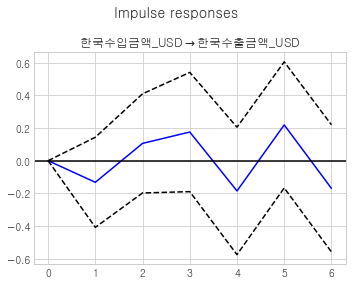

In [41]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='한국수입금액_USD',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

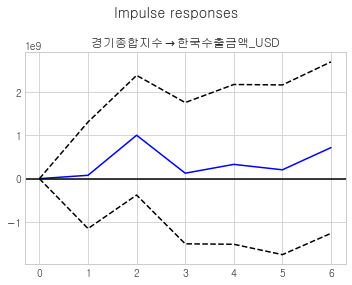

In [42]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='경기종합지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

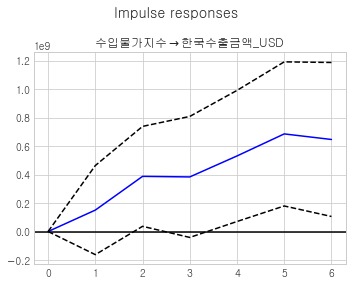

In [43]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='수입물가지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

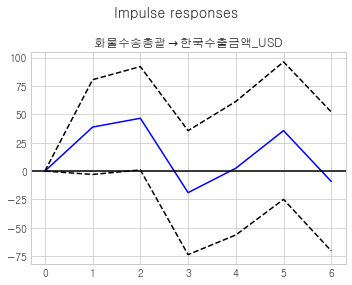

In [44]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='화물수송총괄',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

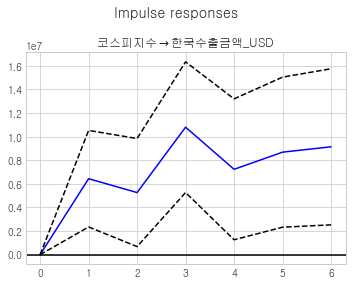

In [45]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='코스피지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

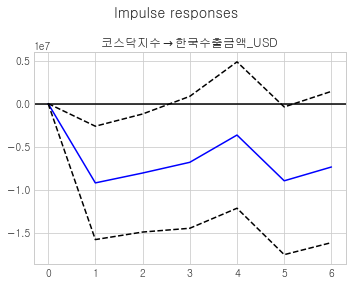

In [46]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='코스닥지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

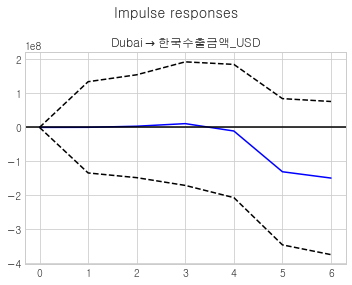

In [47]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='Dubai',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

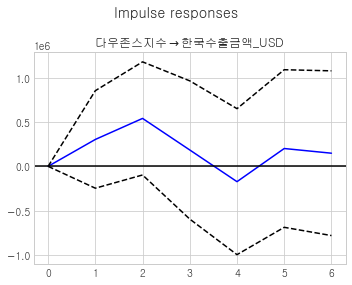

In [48]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='다우존스지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

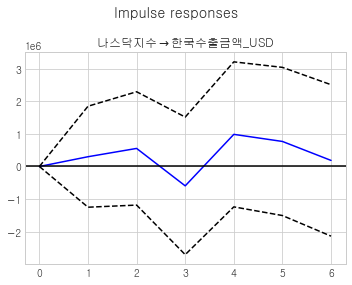

In [49]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='나스닥지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

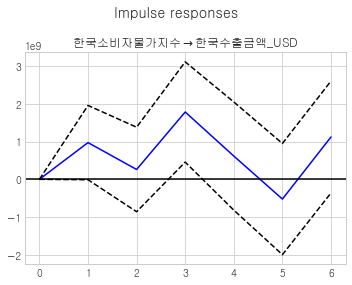

In [50]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='한국소비자물가지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

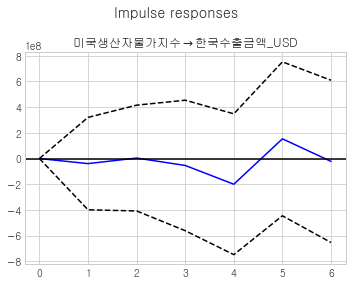

In [51]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='미국생산자물가지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

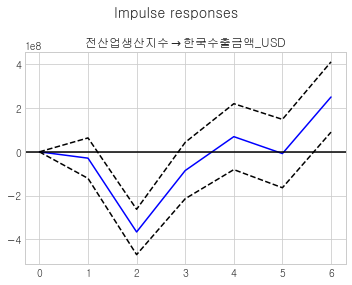

In [52]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='전산업생산지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

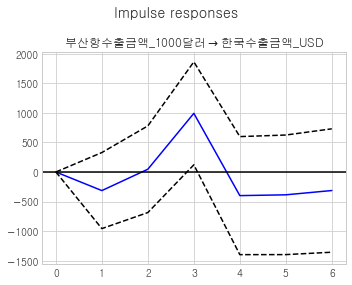

In [53]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='부산항수출금액_1000달러',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

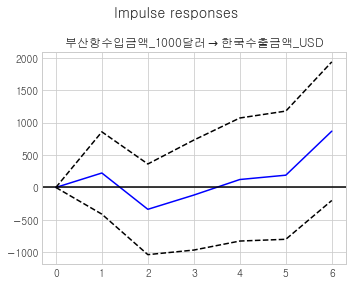

In [54]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='부산항수입금액_1000달러',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

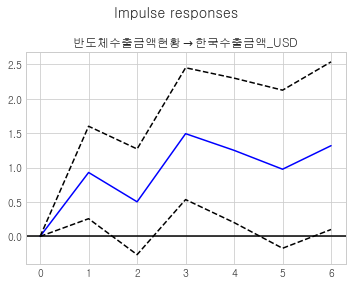

In [55]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='반도체수출금액현황',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

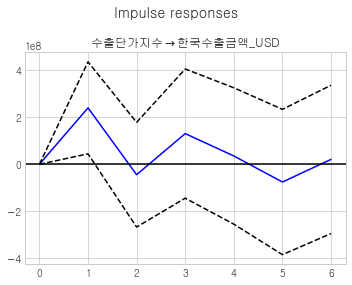

In [56]:
forecast_num = 6
vecm_res.irf(forecast_num).plot(impulse='수출단가지수',response='한국수출금액_USD',figsize=(5,4))
plt.tight_layout() 
plt.show()

###  예측값

In [57]:
pd.options.display.float_format = "{:.0f}".format
forecast, lower, upper = vecm_res.predict(6, 0.05)
print("\npoint forecasts:")
print(pd.DataFrame(forecast.round(2)))


point forecasts:
           0           1   2   3         4    5    6   7     8     9   10  11  \
0 55216358824 57642299047 129 120 136418737 2829 1088  70 35779 15689 104 130   
1 54588287638 56007513803 130 119 128260273 2872 1133  69 36446 15938 105 130   
2 60794817355 58956448952 132 118 141355620 3038 1264  66 37360 16435 106 130   
3 57719932325 56667122829 133 120 131315833 3144 1307  69 38022 16740 106 131   
4 60988812437 57418396257 134 121 135096926 3168 1334  72 37990 16857 107 132   
5 63624751402 57910655983 135 122 130540554 3246 1348  74 38441 17129 107 132   

   12       13      14          15  16  
0 111 10790584 6323968 11518625231  96  
1 112 11882151 5623377 11449467305  95  
2 118 13263873 6997745 12266204279  95  
3 111 12463716 6233523 11705132495  95  
4 118 13262014 6555814 12712975652  96  
5 122 13563164 6527394 12982468051  96  


In [58]:
print("lower 95% interval forecasts:")
print(pd.DataFrame(lower.round(2)))

lower 95% interval forecasts:
           0           1   2   3         4    5    6   7     8     9   10  11  \
0 52133131125 55595837253 128 116 126013663 2684 1000  62 34594 15287 104 128   
1 50956586690 53385382813 129 112 115067411 2659 1019  54 34803 15395 104 127   
2 56230824209 55313689256 131 108 125702090 2771 1127  45 35371 15761 105 127   
3 52196966472 51933430619 132 106 113147867 2822 1146  43 35728 15948 106 127   
4 54787128598 51740912923 133 106 114823509 2796 1149  43 35430 15966 106 126   
5 56750924736 51344283728 133 104 108309801 2831 1143  42 35630 16144 106 126   

   12       13      14          15  16  
0 106  9782972 5495770 10912054713  93  
1 107 10768771 4655396 10533789110  90  
2 112 11903188 5811518 11068525020  88  
3 105 10772435 4838629 10269783151  87  
4 111 11354678 5017068 11062920527  86  
5 116 11451366 4828349 11155225456  84  


In [59]:
print("upper 95% interval forecasts:")
print(pd.DataFrame(upper.round(2)))

upper 95% interval forecasts:
           0           1   2   3         4    5    6   7     8     9   10  11  \
0 58299586523 59688760841 129 123 146823811 2973 1175  78 36964 16091 105 131   
1 58219988585 58629644793 131 127 141453135 3085 1247  84 38088 16480 106 132   
2 65358810501 62599208647 133 129 157009150 3305 1401  87 39349 17109 107 134   
3 63242898178 61400815039 134 133 149483799 3467 1468  94 40316 17531 107 135   
4 67190496276 63095879592 136 137 155370343 3539 1519 101 40550 17748 108 137   
5 70498578069 64477028237 137 140 152771307 3661 1552 106 41253 18113 109 138   

   12       13      14          15  16  
0 115 11798197 7152166 12125195749  98  
1 117 12995531 6591358 12365145500  99  
2 124 14624558 8183972 13463883537 101  
3 117 14154996 7628417 13140481838 104  
4 124 15169350 8094561 14363030777 106  
5 129 15674961 8226439 14809710646 107  


In [60]:
df2 = pd.read_csv('실제값.csv')

In [61]:
pred = pd.DataFrame(forecast.round(2))[0]

In [62]:
rmse = math.sqrt(mean_squared_error(df2['한국수출금액'], pred))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((df2['한국수출금액']- pred)/ df2['한국수출금액'])*100) )

RMSE: 2733172705.207546
MAPE: 2.904538407866711


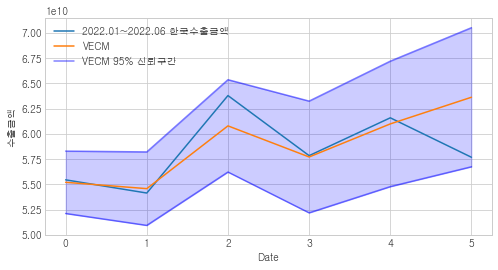

In [69]:
df2 = pd.read_csv('실제값.csv')
plt.figure(figsize=(8,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('수출금액')
plt.plot(df2, label='2022.01~2022.06 한국수출금액')
plt.plot(pred, label='VECM')
plt.plot(pd.DataFrame(lower.round(2))[0], color='blue',alpha=0.5,label='VECM 95% 신뢰구간')
plt.plot(pd.DataFrame(upper.round(2))[0], color='blue',alpha=0.5)
plt.fill_between(pd.DataFrame(upper.round(2))[0].index, pd.DataFrame(lower.round(2))[0], pd.DataFrame(upper.round(2))[0], alpha=0.2,color='blue')
plt.legend(loc=2)

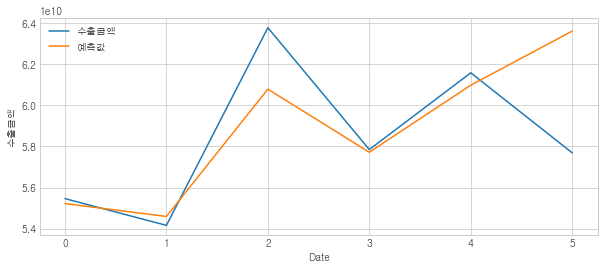

In [63]:
df2 = pd.read_csv('실제값.csv')
plt.figure(figsize=(10,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('수출금액')
plt.plot(df2, label='수출금액')
plt.plot(pred, label='예측값')
plt.legend()